In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import torch
import pandas as pd

import fastai
import dill
from fastai.imports import *
from fastai.vision import *
from fastai.vision.all import *
from fastai.metrics import error_rate, accuracy

In [3]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

## Folder Paths

In [4]:
## Defining Directories
path = Path('../input/hotel-id-2021-fgvc8')

## csv
sample_sub = path/'sample_submission.csv'
labels = path/'train.csv'

## Reading csv submission

In [5]:
train_data = pd.read_csv(labels)
train_data.head(5)

image  chain  hotel_id            timestamp
0  8000d59f6a3d765f.jpg     85     24607  2018-11-28 05:42:31
1  8000febe81817f7f.jpg      6     25389  2017-01-01 07:01:46
2  80053befc2d42fba.jpg      3       672  2018-01-26 13:22:07
3  8007fa0a8fe89f9d.jpg      5     63866  2020-07-03 02:31:31
4  800a4a6b6f6d2df6.jpg      0     12036  2017-09-22 17:59:22

Creating Labels and changing images to include the new paths

In [6]:
train_dir= './kaggle/working/train/'
train_data['label'] =  train_data['chain'].astype(str) + '/' + train_data['image'].astype(str)
train_data['image_path'] = train_dir + train_data['chain'].astype(str) + '/' + train_data['image'].astype(str)

train_data[:3]

image  chain  hotel_id            timestamp  \
0  8000d59f6a3d765f.jpg     85     24607  2018-11-28 05:42:31   
1  8000febe81817f7f.jpg      6     25389  2017-01-01 07:01:46   
2  80053befc2d42fba.jpg      3       672  2018-01-26 13:22:07   

                     label                                      image_path  
0  85/8000d59f6a3d765f.jpg  ./kaggle/working/train/85/8000d59f6a3d765f.jpg  
1   6/8000febe81817f7f.jpg   ./kaggle/working/train/6/8000febe81817f7f.jpg  
2   3/80053befc2d42fba.jpg   ./kaggle/working/train/3/80053befc2d42fba.jpg

## Unzip resized Images

In [7]:
!tar xzvf /kaggle/input/hotelid-224/kaggle_hotelid_train_imgs_224x224.tgz

kaggle/working/train/
kaggle/working/train/24/
kaggle/working/train/24/ccf807817cd2a8cf.jpg
kaggle/working/train/24/83a6d9099853ebb5.jpg
kaggle/working/train/24/b3b34e6c24cc744e.jpg
kaggle/working/train/24/8d67903a76c4197b.jpg
kaggle/working/train/24/9fd28047783ecbc4.jpg
kaggle/working/train/24/fc9cc303c3f0a5e1.jpg
kaggle/working/train/24/c8c42789ec363bdc.jpg
kaggle/working/train/24/eb8f31cc91b29a31.jpg
kaggle/working/train/24/d67f3fa08082ad71.jpg
kaggle/working/train/24/b6a6614c5a4967d3.jpg
kaggle/working/train/24/9a424d7a4d0d73e5.jpg
kaggle/working/train/24/a0b5cb9ad7ca8ad0.jpg
kaggle/working/train/24/f785854936c932e6.jpg
kaggle/working/train/24/d3d38c0c9891afb3.jpg
kaggle/working/train/24/d99aa4b1dcc4c1d9.jpg
kaggle/working/train/24/9ed20d1c188f7772.jpg
kaggle/working/train/24/b9ac6642f2d6cda0.jpg
kaggle/working/train/24/f89c05eeff600e03.jpg
kaggle/working/train/24/c47cf1c51e10ebc9.jpg
kaggle/working/train/24/f7c53c1e8cc31ce0.jpg
kaggle/working/train/24/85c0e8da374a3737.jpg
kaggle/w

## Creating a model with the chain Id

In [8]:
batch_size = 64
def create_dataLoader():
    dataset = ImageDataLoaders.from_df(df = train_data[['image_path', 'chain']],
                                   path = '.',
                                   folder = '.',
                                   valid_pct=0.2,
                                   item_tfms=Resize(128),
                                   batch_tfms=aug_transforms(),
                                   bs=batch_size)
    return dataset

In [9]:
dataset = create_dataLoader()

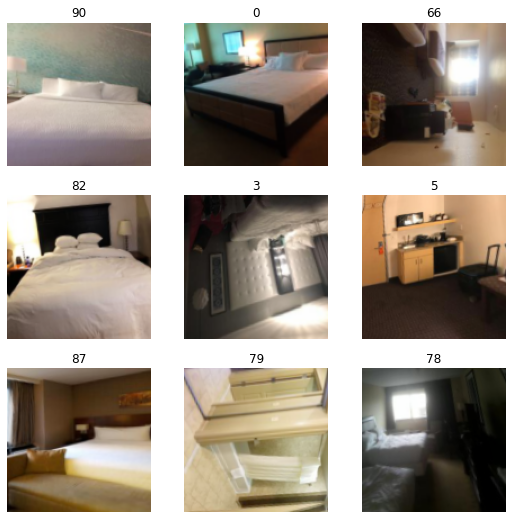

In [10]:
dataset.show_batch()

In [11]:
def training_models(dataset, model_name):
    learn = cnn_learner(dataset,  models.resnet101, 
                        metrics=[accuracy, top_k_accuracy], 
                        opt_func=QHAdam).to_fp16()
    learn.fine_tune(12, 0.005, freeze_epochs=3)
    return learn

In [12]:
%time
model_name ='model_allData_rn101'
learn = training_models(dataset, model_name)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [13]:
learn.export(f'{model_name}.pkl', pickle_module=dill)

In [14]:
!rm -fr './kaggle/working/train'